#### Prepare dataset and download models

In [1]:
!ls /kaggle/input/vgsales

vgsales.csv


In [2]:
!huggingface-cli download bartowski/nvidia_NVIDIA-Nemotron-Nano-9B-v2-GGUF nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf --local-dir . --local-dir-use-symlinks False

⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.
nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf


In [3]:
!ls .

llama-server  nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf


In [4]:
!ls /kaggle/input

democode  llamacpp-sm75-complete-build	vgsales


#### Replaces the CPU based pandas to the GPU based cudf.pandas (called monkey patching)

In [5]:
import cudf.pandas
cudf.pandas.install()

#### NVIDIA Nemotron - 
- Function calling and structured output 
- Python code generation and data analysis tasks 
- Efficiency - runs locally on consumer GPUs
- Accuracy - competitive with larger models on specific tasks

In [6]:
!cp /kaggle/input/llamacpp-sm75-complete-build/build/bin/llama-server ./ && chmod +x llama-server

#### llama server uses stderr to print log info, hence the red output message (not an error)

In [7]:
import subprocess
import os

# Set environment variable
env = os.environ.copy()
env['LD_LIBRARY_PATH'] = f"/kaggle/input/llamacpp-sm75-complete-build/build/bin:{env.get('LD_LIBRARY_PATH', '')}"

# Run the command
process = subprocess.Popen([
    './llama-server',
    '-m', '/kaggle/working/nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf',
    '--host', '0.0.0.0',
    '--port', '8000',
    '-ngl', '99',
    '--ctx-size', '8192',
    '--n-predict', '2048',
    '--threads', '8',
    '--batch-size', '128',
    '--ubatch-size', '128',
    '--cache-reuse', '256',
    '--flash-attn', 'on',
    '--reasoning-format', 'none', 
    '--chat-template-file', '/kaggle/input/democode/chat-template-no-think.jinja',
    '--jinja'
], env=env)

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 2 CUDA devices:
  Device 0: Tesla T4, compute capability 7.5, VMM: yes
  Device 1: Tesla T4, compute capability 7.5, VMM: yes
build: 6789 (3d4e86bb) with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
system info: n_threads = 8, n_threads_batch = 8, total_threads = 4

system_info: n_threads = 8 (n_threads_batch = 8) / 4 | CUDA : ARCHS = 750 | USE_GRAPHS = 1 | PEER_MAX_BATCH_SIZE = 128 | CPU : SSE3 = 1 | SSSE3 = 1 | AVX = 1 | AVX2 = 1 | F16C = 1 | FMA = 1 | BMI2 = 1 | LLAMAFILE = 1 | OPENMP = 1 | REPACK = 1 | 

main: binding port with default address family
main: HTTP server is listening, hostname: 0.0.0.0, port: 8000, http threads: 3
main: loading model
srv    load_model: loading model '/kaggle/working/nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf'
llama_model_load_from_file_impl: using device CUDA0 (Tesla T4) (0000:00:04.0) - 14892 MiB free
llama_model_load_from_fil

#### Wait for server

In [8]:
import time
time.sleep(120) # wait for llm server to come online

#### Initialize the agent with the local Nemotron server

In [9]:
import sys
sys.path.append('/kaggle/input/democode')
from agent import DataScienceAgent
try:
    #agent = DataScienceAgent(verbose=True, force_final_response_after_success=True)
    agent = DataScienceAgent(verbose=True, stream=True, skip_final_response=True)
    print("\nUsing local Nemotron server at http://localhost:8000")
    print("Make sure the server is running with: ./start-nemotron-server.sh\n")
    print("Agent ready! Type your questions in the cells below.\n")
except Exception as e:
    print(f"Error initializing agent: {e}")
    print("\nMake sure the local LLM server is running.")
    print("To use NVIDIA cloud API instead, modify agent initialization in this cell")

[GPU Acceleration] cudf.pandas initialized successfully
DataScienceAgent initialized
  Base URL: http://localhost:8000/v1
  Model: nemotron
  Available tools: ['execute_python_code']


Using local Nemotron server at http://localhost:8000
Make sure the server is running with: ./start-nemotron-server.sh

Agent ready! Type your questions in the cells below.



/usr/local/lib/python3.11/dist-packages/cudf/pandas/__init__.py:65: UserWarning: cudf.pandas detected an already configured memory resource, ignoring 'CUDF_PANDAS_RMM_MODE'=managed_pool
  warnings.warn(


#### How the Agent Works

Tools Available - 
- `execute_python_code` - Writes and runs pandas code with GPU acceleration

Intelligence -
- Understands natural language questions about data 
- Automatically generates appropriate pandas code with GPU acceleration 
- Handles errors gracefully and retries with corrections
- Remembers context across the conversation

Persistent Memory -
- Variables (like dataframes) persist between requests
- Build on previous work without re-loading data
- Example: Load data in one request, analyze it in the next

Performance -
- GPU acceleration automatically enabled for pandas operations
- Falls back to CPU if GPU operations aren't supported
- Execution time tracking for performance monitoring




In [10]:
def reset_conversation():
    """Reset the conversation history."""
    agent.reset_conversation()
    print("✅ Conversation reset. Starting fresh!")

def ask(prompt):
    """Ask the agent a question and get a response."""
    print(f"💬 You: {prompt}\n")
    print("🤖 Agent:")

    # ANSI color codes
    BOLD = '\033[1m'
    GREEN = '\033[92m'
    CYAN = '\033[96m'
    RED = '\033[91m'
    YELLOW = '\033[93m'
    MAGENTA = '\033[95m'
    BLUE = '\033[94m'
    RESET = '\033[0m'

    try:
        # For streaming mode: let output appear in real-time, then highlight [TOOL OUTPUT]
        if agent.stream:
            import io
            import sys
            from IPython.display import display, HTML
            
            # Capture output to post-process for highlighting
            stdout_buffer = io.StringIO()
            old_stdout = sys.stdout
            
            # Use a custom writer that prints immediately AND captures
            class TeeWriter:
                def __init__(self, *writers):
                    self.writers = writers
                
                def write(self, text):
                    for writer in self.writers:
                        writer.write(text)
                    return len(text)
                
                def flush(self):
                    for writer in self.writers:
                        writer.flush()
            
            sys.stdout = TeeWriter(old_stdout, stdout_buffer)
            response = agent.process_prompt(prompt)
            sys.stdout = old_stdout
            
            # Get captured output and apply highlighting to [TOOL OUTPUT] section
            output = stdout_buffer.getvalue()
            #print(output)
            #output = response
            
            # Only re-print the TOOL OUTPUT section with colors
            if True:
                output = '[Agent Response]\n'+response
                lines = output.split('\n')
                in_tool_output = False
                
                for i, line in enumerate(lines):
                    if '[Agent Response]' in line:
                        # Clear the plain [TOOL OUTPUT] and print colored version
                        print(f"\r{BOLD}{MAGENTA}[Agent Response]{RESET}")
                        in_tool_output = True
                    elif in_tool_output and line.strip().startswith('----------------------------------------------------------------------'):
                        print(f"\r{MAGENTA}{line}{RESET}")
                        if i > 0 and not any('[Agent Response]' in lines[j] for j in range(max(0, i-5), i)):
                            in_tool_output = False
                    elif in_tool_output and line.strip() and not line.strip().startswith('----------------------------------------------------------------------'):
                        print(f"\r{GREEN}{line}{RESET}")
            
        else:
            # Non-streaming mode: capture and format output
            import io
            import sys
            
            stdout_buffer = io.StringIO()
            stderr_buffer = io.StringIO()
            
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            
            sys.stdout = stdout_buffer
            sys.stderr = stderr_buffer
            response = agent.process_prompt(prompt)
            sys.stdout = old_stdout
            sys.stderr = old_stderr
            
            # Get the captured output
            output = stdout_buffer.getvalue()
            errors = stderr_buffer.getvalue()
            
            # Add emoji indicators and formatting to execution results
            lines = output.split('\n')
            formatted_lines = []
            in_response_section = False
            
            for line in lines:
                # Highlight AGENT RESPONSE section
                if '[AGENT RESPONSE]' in line:
                    formatted_lines.append(f"{BOLD}{CYAN}[AGENT RESPONSE]{RESET}")
                    in_response_section = True
                elif in_response_section and '----------------------------------------------------------------------' in line:
                    formatted_lines.append(f"{CYAN}{line}{RESET}")
                elif in_response_section and line.strip() and '----------------------------------------------------------------------' not in line and '[' not in line:
                    # This is the actual response content
                    formatted_lines.append(f"{BOLD}{GREEN}{line}{RESET}")
                # Add success/failure indicators
                elif "'success': True" in line or '"success": true' in line:
                    formatted_lines.append(f"✅ {line}")
                    in_response_section = False
                elif "'success': False" in line or '"success": false' in line:
                    formatted_lines.append(f"❌ {line}")
                    in_response_section = False
                else:
                    formatted_lines.append(line)
                    if line.strip() == '':
                        in_response_section = False
            
            print('\n'.join(formatted_lines))
            if errors:
                import sys
                print(errors, file=sys.stderr)
        
        # Display context token information (works for all modes)
        context_info = agent.get_context_tokens()
        print(f"\n{BOLD}{YELLOW}📊 Context Usage:{RESET}")
        print(f"  Messages: {context_info['message_count']}")
        print(f"  Total tokens: ~{context_info['total_tokens']:,}")
        print(f"  Breakdown: System={context_info['breakdown_tokens']['system']}, "
              f"User={context_info['breakdown_tokens']['user']}, "
              f"Assistant={context_info['breakdown_tokens']['assistant']}, "
              f"Tool={context_info['breakdown_tokens']['tool']}")

    except Exception as e:
        print(f"❌ Error: {e}")
        raise

    #return response

#### About the Helper Functions

`reset_conversation()` 
- Clears the conversation history
- Resets the execution environment (removes all variables)
- Useful when starting a fresh analysis 

`ask(prompt)`
- Main interface for chatting with the agent
- Sends your question to the agent
- Displays formatted responses with color coding
  1. Green = Successful execution
  2. Red = Errors
  3. Yellow = Context usage statistics- Shows token usage to monitor context window

#### Interactive Chat

In [11]:
reset_conversation()

Conversation and execution environment reset.
  All variables cleared from execution environment.
✅ Conversation reset. Starting fresh!


In [12]:
%%time
ask("Read /kaggle/input/vgsales/vgsales.csv what are the column names?")

💬 You: Read /kaggle/input/vgsales/vgsales.csv what are the column names?

🤖 Agent:
USER PROMPT: Read /kaggle/input/vgsales/vgsales.csv what are the column names?


  Calling: execute_python_code{"code":"print(df.columns.tolist())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df.columns.tolist())
{
  "success": false,
  "mode": "gpu_accelerated",
  "error": "name 'df' is not defined",
  "error_type": "NameError"
}

  Calling: execute_python_code{"code":"import pandas as pd\n\n# Read the CSV file\nfile_path = \"/kaggle/input/vgsales/vgsales.csv\"\ndf = pd.read_csv(file_path)\n\n# Print column names\nprint(df.columns.tolist())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      import pandas as pd
      
      # Read the CSV file
      file_path = "/kaggle/input/vgsales/vgsales.csv"
      df = pd.read_csv(file_path)
      
      # Print column names
      print(df.columns.tolist())
{
  "success": true,
  "mode": "gpu_accelerated",


In [13]:
%%time

ask("how many rows and columns are there?")

💬 You: how many rows and columns are there?

🤖 Agent:
USER PROMPT: how many rows and columns are there?


  Calling: execute_python_code{"code":"print(f\"Rows: {df.shape[0]}, Columns: {df.shape[1]}\")"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.01
}
[Agent Response]
Rows: 16598, Columns: 11

📊 Context Usage:
  Messages: 7
  Total tokens: ~660
  Breakdown: System=124, User=25, Assistant=131, Tool=379
CPU times: user 55.5 ms, sys: 14.4 ms, total: 69.9 ms
Wall time: 3.04 s


In [14]:
%%time

ask("show me the first 5 rows")

💬 You: show me the first 5 rows

🤖 Agent:
USER PROMPT: show me the first 5 rows


  Calling: execute_python_code{"code":"print(df.head())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df.head())
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.0257
}
[Agent Response]
   Rank                      Name Platform  Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996  Role-Playing  Nintendo   
   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      

In [15]:
%%time

ask("what are the top platforms from the year 2006?")

💬 You: what are the top platforms from the year 2006?

🤖 Agent:
USER PROMPT: what are the top platforms from the year 2006?


  Calling: execute_python_code{"code":"df[df['Year'] == 2006].groupby('Platform').size().sort_values(ascending=False).head(5)"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df[df['Year'] == 2006].groupby('Platform').size().sort_values(ascending=False).head(5))
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.1795
}
[Agent Response]
Platform
PS2     259
DS      202
PSP     190
X360     93
XB       62
dtype: int64

📊 Context Usage:
  Messages: 13
  Total tokens: ~1,345
  Breakdown: System=124, User=42, Assistant=227, Tool=951
CPU times: user 141 ms, sys: 70.6 ms, total: 211 ms
Wall time: 3.93 s


💬 You: Compare the platform and global sales using a bar chart

🤖 Agent:
USER PROMPT: Compare the platform and global sales using a bar chart


  Calling: execute_python_code{"code":"import matplotlib.pyplot as plt\n\n# Filter data for the year 2006\ndf_2006 = df[df['Year'] == 2006]\n\n# Group by platform and sum global sales\nglobal_sales_by_platform = df_2006.groupby('Platform')['Global_Sales'].sum()\n\n# Sort by global sales in descending order\nglobal_sales_by_platform = global_sales_by_platform.sort_values(ascending=False)\n\n# Plot the bar chart\nplt.figure(figsize=(10, 6))\nplt.bar(global_sales_by_platform.index, global_sales_by_platform.values)\nplt.title('Global Sales by Platform in 2006')\nplt.xlabel('Platform')\nplt.ylabel('Global Sales (USD)')\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      import matplotlib.pyplot as plt
      
      # Filter data for the year 2006
      df_2006 = df[df['Ye

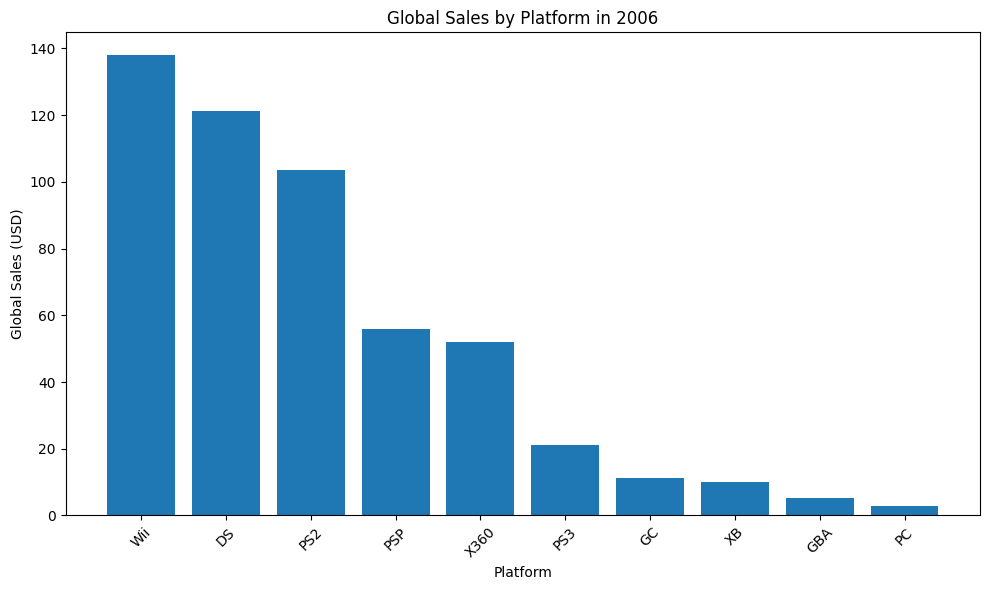

{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.2342
}
    DataFrames created: df_2006
No output from execution, exiting
[Agent Response]

📊 Context Usage:
  Messages: 15
  Total tokens: ~1,559
  Breakdown: System=124, User=56, Assistant=427, Tool=951
CPU times: user 496 ms, sys: 70.1 ms, total: 566 ms
Wall time: 11.2 s


In [16]:
%%time
ask("Compare the platform and global sales using a bar chart")

💬 You: Show all the genres using a pie chart

🤖 Agent:
USER PROMPT: Show all the genres using a pie chart


  Calling: execute_python_code{"code":"import matplotlib.pyplot as plt\n\n# Count the occurrences of each genre\ngenre_counts = df['Genre'].value_counts()\n\n# Plot the pie chart\nplt.figure(figsize=(10, 8))\nplt.pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%', startangle=90)\nplt.title('Distribution of Game Genres')\nplt.axis('equal')  # Equal aspect ratio ensures the pie is circular\nplt.show()","use_gpu":true}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      import matplotlib.pyplot as plt
      
      # Count the occurrences of each genre
      genre_counts = df['Genre'].value_counts()
      
      # Plot the pie chart
      plt.figure(figsize=(10, 8))
      plt.pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%', startangle=90)
      plt.title('Distribution of Game Genres')
      plt.axis('equal')  # Equal aspec

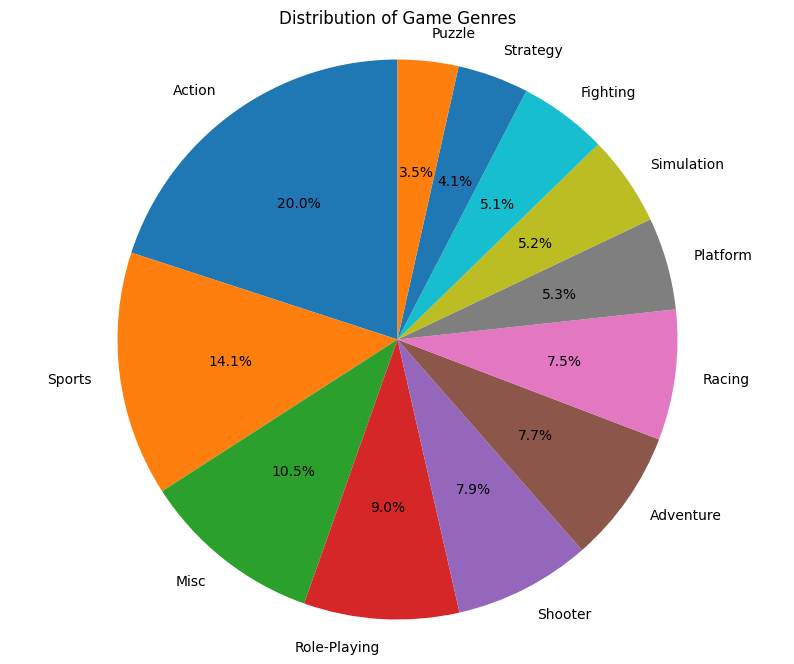

{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.187
}
No output from execution, exiting
[Agent Response]

📊 Context Usage:
  Messages: 17
  Total tokens: ~1,705
  Breakdown: System=124, User=65, Assistant=564, Tool=951
CPU times: user 337 ms, sys: 65 ms, total: 402 ms
Wall time: 10.9 s


In [17]:
%%time
ask("Show all the genres using a pie chart")

💬 You: Use line charts to show the difference between NA sales and EU sales. Make the colour of one green and the other blue

🤖 Agent:
USER PROMPT: Use line charts to show the difference between NA sales and EU sales. Make the colour of one green and the other blue


  Calling: execute_python_code{"code":"import matplotlib.pyplot as plt\n\n# Group by year and calculate total NA and EU sales\ndf_sales = df.groupby('Year')[['NA_Sales', 'EU_Sales']].sum()\n\n# Plot the line chart\nplt.figure(figsize=(12, 6))\nplt.plot(df_sales.index, df_sales['NA_Sales'], color='green', label='NA Sales')\nplt.plot(df_sales.index, df_sales['EU_Sales'], color='blue', label='EU Sales')\nplt.title('NA vs EU Sales Over Time')\nplt.xlabel('Year')\nplt.ylabel('Sales (USD)')\nplt.legend()\nplt.grid(True)\nplt.show()","use_gpu":true}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      import matplotlib.pyplot as plt
      
      # Group by year and calculate total NA and EU sales
      df_sale

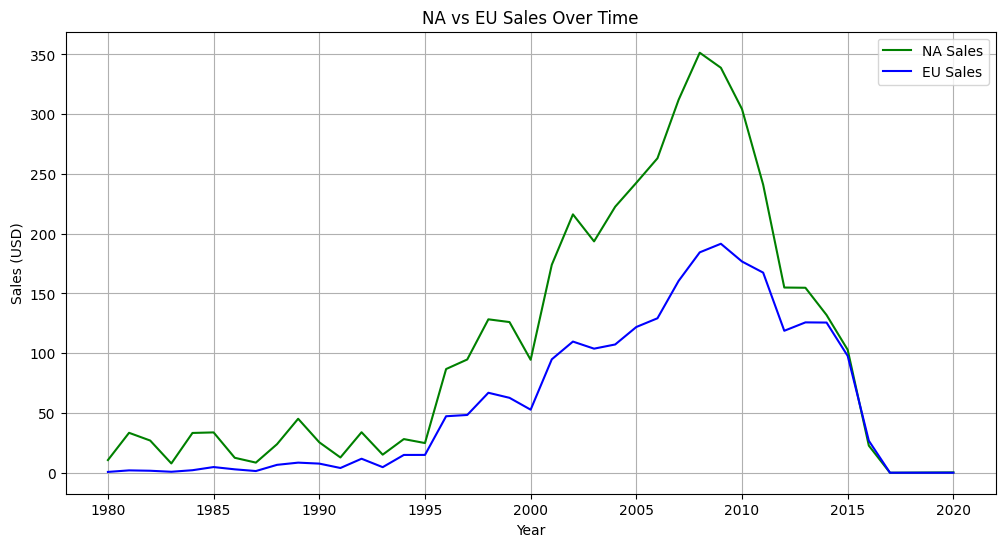

{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.2621
}
    DataFrames created: df_sales
No output from execution, exiting
[Agent Response]

📊 Context Usage:
  Messages: 19
  Total tokens: ~1,901
  Breakdown: System=124, User=95, Assistant=730, Tool=951
CPU times: user 502 ms, sys: 51.2 ms, total: 553 ms
Wall time: 9.2 s


In [18]:
%%time
ask("Use line charts to show the difference between NA sales and EU sales. Make the colour of one green and the other blue")